# AI Algorithms Project : Optimize biscuit manufacturing

A biscuit manufacturing factory is planning to produce a series of biscuits for Christmas. Using
the same roll of dough, the factory aims to create various biscuits in different sizes and shapes.
The goal is to maximize biscuit production from a single dough roll while ensuring the highest
possible profit.
To achieve this goal, we have the following information :
— The roll of dough is of a predefined rectangular length, referred to as ’LENGTH’, representing a one-dimensional problem.
— The roll may contain irregularities, referred to as defects. Each defect has
— a position ‘x‘
— and a class, which could be one of several types (e.g., ’a’, ’b’, ’c’, ...).
— The factory aims to produce a set of biscuits. Each Biscuit can be produced an infinite
number of times, and has :
— a specific size (along the same dimension as the roll)
— a value (price)
— and a threshold for the maximum number of defects of each class it can contain (otherwise it cannot be marketed).
A solution is an assignment of biscuits on the roll. For an assignment to be valid, it needs to :
— be at integer positions
— Ensure no overlap in biscuit placement. For example, if you place a biscuit B1 of size 3 at
position ‘x=2‘, you cannot have any biscuit assigned at positions ‘x=3‘ or ‘x=4‘.
— Ensure that each biscuit placed on the roll contains fewer defects (or an equal number) of
each class than its thresholds permit. For example, a biscuit B1 of size 3 placed at ‘x=2‘
includes all defects in the interval [2, 4]. If there are 3 defects of class ’a’ in this interval,
and B1’s threshold for class ’a’ is a maximum of 2 defects, then the assignment is invalid.
— Ensure that the sum of the sizes of the assigned biscuits does not exceed the length of the
roll of dough.
The value of a solution is the sum of the values of the individual biscuits placed on it. Any part
of the roll of dough without a biscuit assigned is considered to have a value of 0.
2.1 Benchmark
For this project, the following assumptions are made :
— The length of the roll of dough is set to 500 units.
— The roll has three classes of defects (’a’, ’b’, and ’c’). The set of defects and their positions
on the roll are available in the ’defects.csv’ file.
— The biscuit manufacturing factory aims to produce 4 types of biscuits, which are :
— Biscuit 0 with a length of 4, a value 6, and maximum allowed defects as {'a' : 4, 'b' : 2, 'c' : 3}
— Biscuit 1 with a length of 8, a value 12, and maximum allowed defects as{'a' : 5, 'b' : 4, 'c' : 4}
— Biscuit 2 with a length of 2, a value 1, and maximum allowed defects as {'a' : 1, 'b' : 2, 'c' : 1}
— Biscuit 3 with a length of 5, a value 8, and maximum allowed defects as {'a' : 2, 'b' : 3, 'c' : 2}

# 1- Define the problem
Our goal here is to maximize the profit from a roll of doughby creating several biscuits while adressing specific constraints.
Our roll has a fixed length, it contains defects,
a biscuit is defined by its:

1.   size
2.   value
2.   tolerance for certain defect classes




We want to arrange the biscuits on the roll of dough optimally so as to maximize the profit.



# 2 - Python Implementation


In [220]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [221]:
class Biscuit:
    """
    A class to represent a biscuit.
    
    Attributes
    ----------
    size : int
        the size of the biscuit
    value : int
        the value of the biscuit
    defects : dict
        the maximum number of defects of each class the biscuit can contain
    """
    
    def __init__(self, size, value, defects_threshold):
        self.size = size
        self.value = value
        self.defects_threshold = defects_threshold

    def __str__(self):
        return f'Biscuit(size={self.size}, value={self.value}, defects={self.defects_threshold})'

class Defect:
    """
    A class to represent a defect.
    
    Attributes
    ----------
    position : int
        the position of the defect
    classe : str
        the class of the defect
    """
    
    def __init__(self, position, classe):
        self.position = position
        self.classe = classe

    def __str__(self):
        return f'Defect(position={self.position}, classe={self.classe})'
        

#### Let's define our 4 type of biscuits that the factory is producing.

#### We will also define the defects in the roll of dough as a list of Defect objects.

In [235]:
# Read the defects from the csv file

defects = pd.read_csv('defects.csv', header=None, names=['position', 'classe'])
defects = [Defect(position, classe) for position, classe in zip(defects['position'], defects['classe'])]
# we remove the first value to avoid position x and class = class
defects = defects[1:]



biscuits = [
    Biscuit(size=4, value=6, defects_threshold={'a': 4, 'b': 2, 'c': 3}),
    Biscuit(8, 12, {'a': 5, 'b': 4, 'c': 4}),
    Biscuit(2, 1, {'a': 1, 'b': 2, 'c': 1}),
    Biscuit(5, 8, {'a': 2, 'b': 3, 'c': 2})
]

# display the 10 first defects 
print('Defects:')
for defect in defects[:10]:
    print(defect)

Defects:
Defect(position=355.44933495113816, classe=c)
Defect(position=92.49623624899967, classe=a)
Defect(position=141.87679475713, classe=c)
Defect(position=431.833901528095, classe=c)
Defect(position=435.02846071222535, classe=c)
Defect(position=205.80069498110913, classe=a)
Defect(position=34.68761156005529, classe=b)
Defect(position=443.5663536577713, classe=a)
Defect(position=69.42321664429218, classe=a)
Defect(position=301.2810691469357, classe=a)


In [223]:
class Roll:
    """
    A class to represent a roll of dough.
    It contains also the information of the assigned biscuits and their positions.
    
    Attributes
    ----------
    length : int
        the length of the roll
    defects : list
        the list of defects in the roll
    assigned_biscuits : tuple(Biscuit, int)
        the list of assigned biscuits with the type of biscuit and its starting position
    
    Methods
    -------
    
    """
    
    def __init__(self, length=500, defects = defects):
        self.length = length
        self.defects = defects
        self.assigned_biscuits = []
        
    def __str__(self):
        return f'Roll(length={self.length}, defects={self.defects}, assigned_biscuits={self.assigned_biscuits})'
    
    def check_constraints(self, biscuit, position):
        """ 
        Check if an assignment of a biscuit on the roll is valid.
        It checks if the assignment respects the following constraints:
        - There is no overlap in biscuit placement
        - Each biscuit placed on the roll contains fewer defects (or an equal number) of each class than its thresholds permit
        - The sum of the sizes of the assigned biscuits does not exceed the length of the roll of dough
        
        Args:
            biscuit (Biscuit): the biscuit to be placed
            position (int): the position of the biscuit in the roll
            
        Returns:
            bool: True if the assignment is valid, False otherwise
        """
        
        # Check if there is no overlap in biscuit placement
        for assigned_biscuit in self.assigned_biscuits:
            if position <= assigned_biscuit[1] < position + biscuit.size: # if the starting position of the already placed biscuit is in the interval of the new biscuit
                return False
            if assigned_biscuit[1] <= position < assigned_biscuit[1] + assigned_biscuit[0].size: # if the starting position of the new biscuit is in the interval of the already placed biscuit
                return False
        
        # Check if the placement of the biscuit does not exceed the maximum number of defects of each class
        for classe in biscuit.defects_threshold.keys():
            # Get the number of defects of the class in the interval of the biscuit
            nb_defects = len([defect for defect in self.defects if defect.classe == classe and position <= float(defect.position) < position + biscuit.size])
            if nb_defects > biscuit.defects_threshold[classe]: # if the number of defects of the class in the interval of the biscuit is greater than the maximum number of defects of the class
                return False
                
        
        # Check if the sum of the sizes of the assigned biscuits does not exceed the length of the roll of dough
        if sum([assigned_biscuit[0].size for assigned_biscuit in self.assigned_biscuits]) + biscuit.size > self.length:
            return False
        
        return True
    
    def total_value(self):
        """ 
        Calculate the total value of the assigned biscuits on the roll
        
        Returns:
            int: the total value of the assigned biscuits
        """
        return sum([assigned_biscuit[0].value for assigned_biscuit in self.assigned_biscuits])
    
    def place_biscuit(self, biscuit, position):
        """
        Place a biscuit on the roll at a given position while checking the constraints
        
        Args:
            biscuit (Biscuit): the biscuit to be placed
            position (int): the position of the biscuit in the roll
        """
        if self.check_constraints(biscuit, position):
            self.assigned_biscuits.append((biscuit, position))
            return True
        return False
        
    def remove_biscuit(self, biscuit, position):
        """
        Remove a biscuit from the roll at a given position
        
        Args:
            biscuit (Biscuit): the biscuit to be removed
            position (int): the position of the biscuit in the roll
        """
        self.assigned_biscuits.remove((biscuit, position))

#### Let's create our roll of dough with a length of 500 units and assign the defects to it.

In [265]:
roll = Roll()
roll_test = Roll()
roll_test.place_biscuit(biscuits[0], 0)
roll_test.place_biscuit(biscuits[1], 4)
roll_test.place_biscuit(biscuits[1], 126)
roll_test.place_biscuit(biscuits[2], 12)
roll_test.place_biscuit(biscuits[3], 14)
roll_test.place_biscuit(biscuits[0], 100)
roll_test.place_biscuit(biscuits[2], 144)
roll_test.place_biscuit(biscuits[3], 146)

False

#### Let's define a function to visualize the roll of dough with the assigned biscuits and the defects.


In [297]:
def visualize_roll(roll, biscuits=biscuits):
    """
    Visualize the roll of dough with each biscuit type in a different color
    
    Args:
        roll (Roll): the roll of dough
        biscuits (list): the list of biscuits produced by the factory
    """

    
    # Plot the roll of dough
    plt.figure(figsize=(20, 1))
    plt.xlim(0, roll.length)
    plt.ylim(0, 1)
    plt.yticks([])
    plt.xticks(np.arange(0, roll.length, 10))
    plt.title('Roll of dough with different biscuits')
    
    # Define the colors for each biscuit type
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

    for i, assigned_biscuit in enumerate(roll.assigned_biscuits):
        plt.barh(0, assigned_biscuit[0].size, left=assigned_biscuit[1], height=2, color=colors[biscuits.index(assigned_biscuit[0])], edgecolor='black', linewidth=1)
    
    # define the labels for the legend
    for i, biscuit in enumerate(biscuits):
        plt.barh(0, 0, color=colors[i], label=f'Biscuit {i}')
    
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), fancybox=True, shadow=True, ncol=5)
    plt.show()
    
        

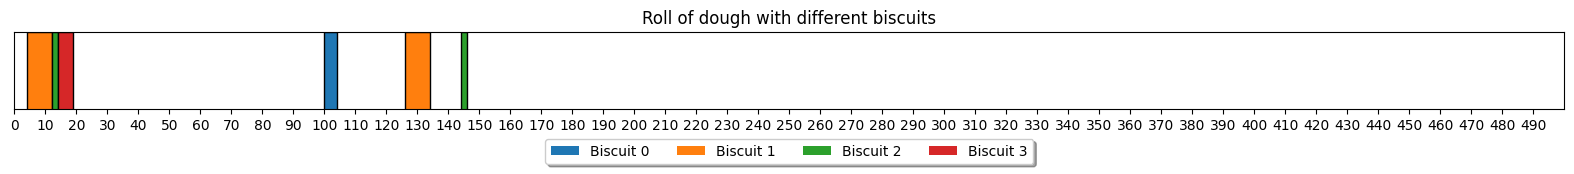

In [298]:
visualize_roll(roll_test)

# Implement a heuristic algorithm

## Pertinence pour Votre Projet
Dans votre projet de fabrication de biscuits, une approche heuristique peut être très efficace pour placer les biscuits sur le rouleau de manière à maximiser le profit, en tenant compte des contraintes de défauts et de la taille du rouleau. Une heuristique possible pourrait être de prioriser le placement des biscuits avec le plus haut ratio valeur/taille, tout en respectant les contraintes de défauts.

## Squelette de l'IA Heuristique
Pour mettre en œuvre une IA heuristique dans votre projet, vous pourriez envisager les composants suivants :

- Fonction de Sélection Heuristique :
Détermine quel biscuit placer ensuite en fonction d'une règle simple, par exemple, en choisissant le biscuit avec le meilleur ratio valeur/taille ou le moins de contraintes de défauts.

- Fonction de Placement de Biscuits :
Place le biscuit sélectionné sur le rouleau à la position optimale tout en respectant les contraintes.

- Boucle Principale pour la Construction de la Solution :
Répète le processus de sélection et de placement jusqu'à ce que le rouleau soit plein ou qu'aucun autre biscuit ne puisse être placé.

- Fonction d'Évaluation :
Évalue la valeur totale des biscuits placés sur le rouleau et vérifie si les contraintes sont respectées.

- Optionnel - Ajustement et Amélioration :
Après la construction initiale, vous pouvez envisager d'ajouter une phase où la solution est ajustée pour tenter d'améliorer la valeur totale, par exemple en remplaçant certains biscuits ou en ajustant leurs positions.

# Fonctionnement du Hill Climbing pour Votre Problème
- Le Hill Climbing est une méthode d'optimisation qui vise à améliorer progressivement une solution en faisant de petits changements. Voici comment l'appliquer à votre projet de placement de biscuits :

- Solution Initiale : Commencez avec une solution initiale. Cette solution peut être un rouleau vide ou un rouleau avec une disposition aléatoire ou simple des biscuits.

- Génération de Voisins : À partir de cette solution, générez des "voisins" en faisant de petits changements. Par exemple, ajoutez un biscuit, déplacez un biscuit existant, ou remplacez un type de biscuit par un autre.

- Évaluation : Évaluez chaque solution voisine. Dans votre cas, cela signifierait calculer la valeur totale des biscuits sur le rouleau tout en vérifiant que les contraintes (comme les défauts et la longueur maximale du rouleau) sont respectées.

- Choix de la Meilleure Solution : Si une solution voisine est meilleure (c'est-à-dire, elle a une valeur totale plus élevée sans enfreindre les contraintes), remplacez votre solution actuelle par cette solution voisine.

- Répétition : Répétez ce processus jusqu'à ce qu'aucune amélioration ne soit possible ou qu'un critère d'arrêt soit atteint (par exemple, un nombre maximum d'itérations).

# Implémentation du Hill Climbing
#### Pour implémenter le Hill Climbing, vous pourriez avoir besoin des éléments suivants :

- Fonction pour Générer des Voisins :
Cette fonction modifie légèrement la disposition actuelle des biscuits pour créer de nouvelles configurations.
Par exemple, elle pourrait essayer d'ajouter un biscuit à différentes positions, déplacer un biscuit existant, ou remplacer un type de biscuit par un autre.

- Fonction d'Évaluation :
Utilisez ou modifiez votre méthode existante pour évaluer la valeur totale des biscuits sur le rouleau et vérifier si les contraintes sont respectées.

- Boucle Principale de Hill Climbing :
Cette boucle contrôle le processus d'optimisation, en comparant les solutions actuelles et voisines, et en mettant à jour la solution actuelle si une meilleure est trouvée.

- Critère d'Arrêt :
Définissez un critère d'arrêt pour la boucle principale, comme un nombre maximum d'itérations ou l'absence d'amélioration après un certain nombre de tentatives.

#### Let's start by creating our initial solution. In case the hill climbing get stuck in a local optimum, we will try adding some randomization to the initial solution. So we can see how this randomization can help us get a better solution.

For this initial solution we will randomly take a biscuit and place it at the first position where it can be placed. We will repeat this process until we can't place any more biscuits.

In [227]:
def generate_initial_solution(biscuits):
    """
    Generate an initial solution.
    
    Args:
        biscuits (list): the list of biscuits produced by the factory
        roll (Roll): the empty roll of dough
        
    Returns:
        Roll: the roll of dough with the biscuits placed on it
    """
    # We make a copy of the list of biscuits so we can remove the biscuit type if it can't be placed anymore
    biscuits = biscuits.copy()
    roll = Roll()
    while True:
        placed = False
        current_biscuit = np.random.choice(biscuits)
        for position in range(roll.length - current_biscuit.size + 1):
            if roll.place_biscuit(current_biscuit, position):
                placed = True
                break
        if not placed: # if the biscuit can't be placed after trying all the positions, we remove it from the list
            biscuits.remove(current_biscuit)
        if len(biscuits) == 0:
            break
    return roll

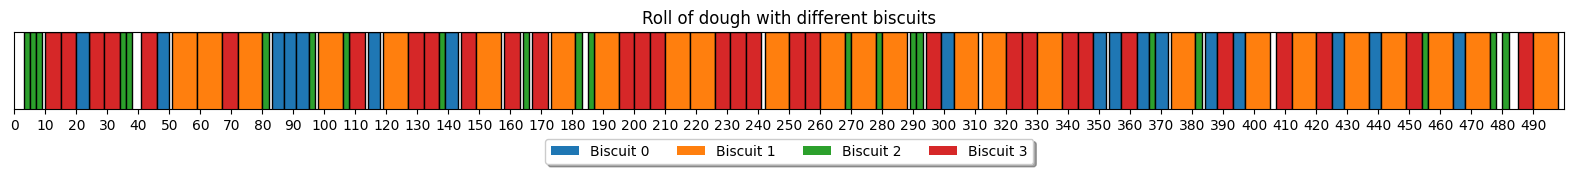

The total value of the roll is 671


In [302]:
roll_initial = generate_initial_solution(biscuits)
visualize_roll(roll_initial)
print(f'The total value of the roll is {roll_initial.total_value()}')